# Tweet Sentiment Analysis with LSTM

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

### Load data

In [2]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## LSTM Encoder

### train a single-layer lstm network

First of all, we'll build a single-layer LSTM network for the analysis.

1. Train the network for 1000 iterations. In each iteration, use batch_size samples to train the network.
2. For every 50 iterations, apply the network on the test set, and print out the test accuracy and mean loss.

With these settings, what is the accuracy and then parameter tuning to achieve a higher accuracy

In [3]:
# define a linear layer, y = x*w + b
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b

In [4]:
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
#init_state = lstm_cell.zero_state(batch_size, tf.float32)
#outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [5]:
print(test_tweets.shape)

(1000, 20)


In [7]:
# Training function
num_steps = 1000
start_id = 0
train_losses = []
train_accs = []
test_losses = []
test_accs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        #print(step)
        batch_tweets = train_tweets[start_id:min(start_id + batch_size, train_tweets.shape[0])]
        batch_labels = train_labels[start_id:min(start_id + batch_size, train_tweets.shape[0])]
        if start_id + batch_size >= train_tweets.shape[0]:
            start_id = 0
        else:
            start_id += batch_size
        feed_dict = {tweets: batch_tweets, labels: batch_labels}
        _, train_loss, train_acc = sess.run([optimizer, loss, acc], feed_dict=feed_dict)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        if (step % 50 == 0):
            num_itrs = int(np.ceil(test_tweets.shape[0] / batch_size))
            test_loss = 0
            test_acc = 0
            for i in range(num_itrs):
                #print(i)
                test_start_id = i * batch_size
                test_end_id = min((i+1) * batch_size, test_tweets.shape[0])
                batch_tweets = test_tweets[test_start_id:test_end_id]
                batch_labels = test_labels[test_start_id:test_end_id]
                feed_dict = {tweets: batch_tweets, labels: batch_labels}
                test_l, test_a = sess.run([loss, acc], feed_dict=feed_dict)
                test_loss += test_l * (test_end_id - test_start_id)
                test_acc += test_a * (test_end_id - test_start_id)
            test_loss /= test_tweets.shape[0]
            test_acc /= test_tweets.shape[0]
            print("step {}: train loss = {}, test loss = {}, train acc = {}, test acc = {}".format(step, train_loss, test_loss, train_acc, test_acc))
            

step 0: train loss = 0.6926367878913879, test loss = 0.6922867426872253, train acc = 0.53125, test acc = 0.547
step 50: train loss = 0.5944596529006958, test loss = 0.646370602607727, train acc = 0.6875, test acc = 0.6290000009536744
step 100: train loss = 0.6180109977722168, test loss = 0.5917654404640198, train acc = 0.671875, test acc = 0.676
step 150: train loss = 0.5727746486663818, test loss = 0.5866021471023559, train acc = 0.734375, test acc = 0.6969999995231628
step 200: train loss = 0.5294105410575867, test loss = 0.5623033666610717, train acc = 0.703125, test acc = 0.7170000004768372
step 250: train loss = 0.45725739002227783, test loss = 0.5448545160293579, train acc = 0.765625, test acc = 0.7210000004768372
step 300: train loss = 0.6063907146453857, test loss = 0.5411413726806641, train acc = 0.71875, test acc = 0.7269999990463257
step 350: train loss = 0.5294427871704102, test loss = 0.5587043895721435, train acc = 0.75, test acc = 0.7090000009536743
step 400: train loss 

### train a two-layer lstm network

Next, we look at a slightly more difficult network structure: a double-layer LSTM. The output of the first LSTM cell is propagated to the second LSTM cell. We only need to make small modifications to the previous network to construct this one.


In [6]:
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
double_lstm_cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.LSTMCell(hidden_size) for _ in range(2)])

# define the op that runs the LSTM, across time, on the data
#init_state = lstm_cell.zero_state(batch_size, tf.float32)
#outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(double_lstm_cell, tweets_onehot, dtype=tf.float32)
# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1][-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [9]:
# Training function
num_steps = 1000
start_id = 0
train_losses = []
train_accs = []
test_losses = []
test_accs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        #print(step)
        batch_tweets = train_tweets[start_id:min(start_id + batch_size, train_tweets.shape[0])]
        batch_labels = train_labels[start_id:min(start_id + batch_size, train_tweets.shape[0])]
        if start_id + batch_size >= train_tweets.shape[0]:
            start_id = 0
        else:
            start_id += batch_size
        feed_dict = {tweets: batch_tweets, labels: batch_labels}
        _, train_loss, train_acc = sess.run([optimizer, loss, acc], feed_dict=feed_dict)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        if (step % 50 == 0):
            num_itrs = int(np.ceil(test_tweets.shape[0] / batch_size))
            test_loss = 0
            test_acc = 0
            for i in range(num_itrs):
                #print(i)
                test_start_id = i * batch_size
                test_end_id = min((i+1) * batch_size, test_tweets.shape[0])
                batch_tweets = test_tweets[test_start_id:test_end_id]
                batch_labels = test_labels[test_start_id:test_end_id]
                feed_dict = {tweets: batch_tweets, labels: batch_labels}
                test_l, test_a = sess.run([loss, acc], feed_dict=feed_dict)
                test_loss += test_l * (test_end_id - test_start_id)
                test_acc += test_a * (test_end_id - test_start_id)
            test_loss /= test_tweets.shape[0]
            test_acc /= test_tweets.shape[0]
            print("step {}: train loss = {}, test loss = {}, train acc = {}, test acc = {}".format(step, train_loss, test_loss, train_acc, test_acc))
            

step 0: train loss = 0.6932448148727417, test loss = 0.6926844396591186, train acc = 0.4375, test acc = 0.539
step 50: train loss = 0.5435563325881958, test loss = 0.6287727279663086, train acc = 0.734375, test acc = 0.6510000009536743
step 100: train loss = 0.585548996925354, test loss = 0.590353440284729, train acc = 0.671875, test acc = 0.6829999990463257
step 150: train loss = 0.5590313673019409, test loss = 0.5840771899223328, train acc = 0.75, test acc = 0.7080000009536743
step 200: train loss = 0.5114988088607788, test loss = 0.5538660912513733, train acc = 0.765625, test acc = 0.7199999990463257
step 250: train loss = 0.45484456419944763, test loss = 0.5377914710044861, train acc = 0.75, test acc = 0.735
step 300: train loss = 0.5865883231163025, test loss = 0.5355859475135804, train acc = 0.71875, test acc = 0.7410000004768371
step 350: train loss = 0.5432904958724976, test loss = 0.5504963159561157, train acc = 0.734375, test acc = 0.727
step 400: train loss = 0.5681610107421

## Embedding Lookup layer

###  Define an embedding layer

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. 

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness). 

In [7]:
def embedding(input_, vocab_size, output_size, name):
    """
    1. Define an embedding matrix
    2. return both the lookup results and the embedding matrix.
    """
    word_embed = tf.get_variable(name=name, shape=[vocab_size, output_size])
    lookup = tf.nn.embedding_lookup(word_embed, input_)
    return (lookup, word_embed)

### Train a single lstm network with embedding layer

Build a single-layer LSTM network according to the network structure. Then, train the network with the training function.

In [109]:
# EMBEDDING SINGLE-LAYER LSTM
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 128
embed_size = 128

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_embed, embed = embedding(tweets, vocab_size, embed_size, 'embed')

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
#init_state = lstm_cell.zero_state(batch_size, tf.float32)
#outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_embed, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [110]:
# Training function
num_steps = 1000
start_id = 0
train_losses = []
train_accs = []
test_losses = []
test_accs = []
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for step in range(num_steps):
    #print(step)
    batch_tweets = train_tweets[start_id:min(start_id + batch_size, train_tweets.shape[0])]
    batch_labels = train_labels[start_id:min(start_id + batch_size, train_tweets.shape[0])]
    if start_id + batch_size >= train_tweets.shape[0]:
        start_id = 0
    else:
        start_id += batch_size
    feed_dict = {tweets: batch_tweets, labels: batch_labels}
    _, train_loss, train_acc = sess.run([optimizer, loss, acc], feed_dict=feed_dict)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    if (step % 50 == 0):
        num_itrs = int(np.ceil(test_tweets.shape[0] / batch_size))
        test_loss = 0
        test_acc = 0
        for i in range(num_itrs):
            #print(i)
            test_start_id = i * batch_size
            test_end_id = min((i+1) * batch_size, test_tweets.shape[0])
            batch_tweets = test_tweets[test_start_id:test_end_id]
            batch_labels = test_labels[test_start_id:test_end_id]
            feed_dict = {tweets: batch_tweets, labels: batch_labels}
            test_l, test_a = sess.run([loss, acc], feed_dict=feed_dict)
            test_loss += test_l * (test_end_id - test_start_id)
            test_acc += test_a * (test_end_id - test_start_id)
        test_loss /= test_tweets.shape[0]
        test_acc /= test_tweets.shape[0]
        print("step {}: train loss = {}, test loss = {}, train acc = {}, test acc = {}".format(step, train_loss, test_loss, train_acc, test_acc))  
            

step 0: train loss = 0.6931838989257812, test loss = 0.6927768788337707, train acc = 0.46875, test acc = 0.5430000004768372
step 50: train loss = 0.5806010961532593, test loss = 0.613920443058014, train acc = 0.7109375, test acc = 0.6589999995231628
step 100: train loss = 0.5398669242858887, test loss = 0.5551366386413574, train acc = 0.75, test acc = 0.7169999995231628
step 150: train loss = 0.6041603684425354, test loss = 0.544174467086792, train acc = 0.7109375, test acc = 0.7410000023841858
step 200: train loss = 0.5747165679931641, test loss = 0.5248050346374512, train acc = 0.71875, test acc = 0.760000002861023
step 250: train loss = 0.5489137768745422, test loss = 0.518502375125885, train acc = 0.703125, test acc = 0.752
step 300: train loss = 0.42131972312927246, test loss = 0.5149349765777588, train acc = 0.828125, test acc = 0.760000002861023
step 350: train loss = 0.45854446291923523, test loss = 0.5054869620800019, train acc = 0.8046875, test acc = 0.7700000019073486
step 4

### Visualize word vectors via tSNE

First, we retrieve **embedding matrix** from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector. 

And then, we visualize some interesting word pairs in 2D panel.

In [111]:
female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]

In [112]:
from sklearn.manifold import TSNE

# get the value of our embedding matrix
embed_mat = sess.run(embed)
dim2_embed = TSNE(n_components=2).fit_transform(embed_mat)

In [113]:
reverse_vocab = {}
for k in range(vocab_size):
    v = vocabulary[k]
    reverse_vocab[v] = k
print(dim2_embed.shape)

(7597, 2)


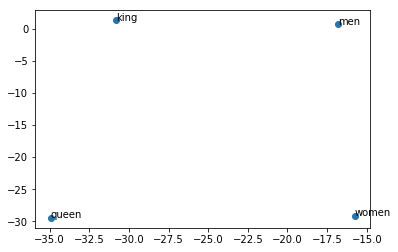

In [114]:
plot_words = female_male
#plot_words = country_capital
plot_x = []
plot_y = []
for i in range(len(plot_words)):
    wordvec = dim2_embed[reverse_vocab[plot_words[i].lower()]]
    plot_x.append(wordvec[0])
    plot_y.append(wordvec[1])
plt.figure()
plt.scatter(plot_x, plot_y)
for i in range(len(plot_words)):
    w = plot_words[i]
    plt.annotate(w, xy=(plot_x[i], plot_y[i]))
plt.show()

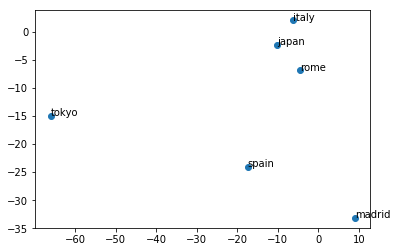

In [115]:
plot_words = country_capital
plot_x = []
plot_y = []
for i in range(len(plot_words)):
    wordvec = dim2_embed[reverse_vocab[plot_words[i].lower()]]
    plot_x.append(wordvec[0])
    plot_y.append(wordvec[1])
plt.figure()
plt.scatter(plot_x, plot_y)
for i in range(len(plot_words)):
    w = plot_words[i]
    plt.annotate(w, xy=(plot_x[i], plot_y[i]))
plt.show()